cifar-10: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_tuner as kt

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
split = ['train+test[50%:]', 'test[:50%]']
(data_train, data_test), data_info = tfds.load(name='cifar10', split=split, 
                                               as_supervised=True, shuffle_files=True, with_info=True)

classes = data_info.features["label"].names 

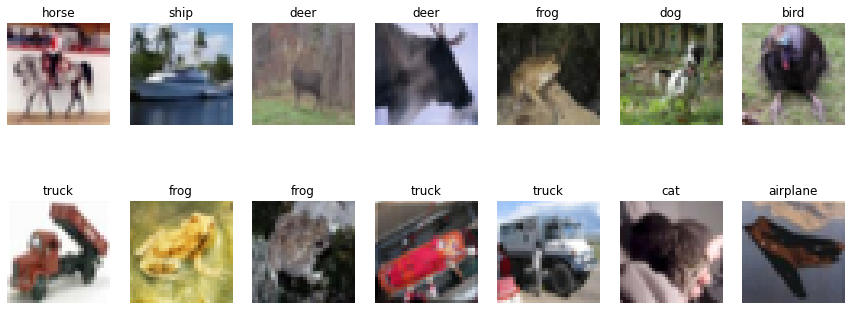

In [3]:
plt.figure(figsize=(15,6))

rows = 2
for i,tfd in zip(range(14),data_train):
    plt.subplot(rows,7,i+1)
    plt.title(classes[tfd[1].numpy()])
    plt.axis('off')
    plt.imshow(tfd[0])

In [4]:
print('Classes: ', classes)
print('Total Number of Classes: {}'.format(len(classes)))
print('Total Number of Training Images: {}'.format(len(data_train)))
print('Total Number of Validation Images: {}'.format(len(data_test)))

Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Total Number of Classes: 10
Total Number of Training Images: 55000
Total Number of Validation Images: 5000


In [5]:
def to_array(data):
    x, y = [], []
    for i,l in data:
        x.append(i.numpy())
        y.append(l.numpy())
    X = np.asarray(x)
    Y = np.asarray(y)
    return X,Y

In [6]:
def normalize_img(image,label):
    return tf.cast(image,tf.float32)/255.,label

In [7]:
data_train = data_train.map(normalize_img,num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
(X_train,Y_train) = to_array(data_train)

In [9]:
data_train = data_train.cache().batch(32).shuffle(len(data_train)).prefetch(buffer_size=tf.data.AUTOTUNE)
data_test = data_test.cache().batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
def _model(activation = 'relu',optimizer='sgd',learning_rate=0.01):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(32,32,3)),
        tf.keras.layers.Dense(1024, activation=activation),
        tf.keras.layers.Dense(950, activation=activation),
        tf.keras.layers.Dense(1024, activation=activation),
        tf.keras.layers.Dense(900, activation=activation),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dense(len(classes),activation='softmax')
    ])
    
    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(build_fn=_model, verbose=0)
#model = _model()

C:\Users\User\AppData\Local\Temp\ipykernel_10536\3930941110.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=_model, verbose=0)


In [12]:
optimizer = ['rmsprop','adam','sgd']
learning_rate = [0.001, 0.01, 0.1]
activation = ['relu', 'sigmoid','linear']

In [13]:
param_grid = dict(activation=activation,optimizer=optimizer,learning_rate=learning_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train, Y_train)

In [14]:
print("Best parameters: {}".format(grid_result.best_params_))

Best parameters: {'activation': 'relu', 'learning_rate': 0.01, 'optimizer': 'sgd'}


In [15]:
grid_result.score(X_train, Y_train)

0.40403636363636364

In [16]:
model = _model(optimizer=grid_result.best_params_['optimizer'],
                activation=grid_result.best_params_['activation'],
                learning_rate=grid_result.best_params_['learning_rate'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              3146752   
                                                                 
 dense_7 (Dense)             (None, 950)               973750    
                                                                 
 dense_8 (Dense)             (None, 1024)              973824    
                                                                 
 dense_9 (Dense)             (None, 900)               922500    
                                                                 
 dense_10 (Dense)            (None, 512)               461312    
                                                                 
 dense_11 (Dense)            (None, 10)               

In [18]:
trainHistory = model.fit(data_train, epochs=15)

Epoch 1/15
1719/1719 [==============================] - 31s 17ms/step - loss: 1.8607 - accuracy: 0.3323
Epoch 2/15
1719/1719 [==============================] - 30s 17ms/step - loss: 1.6408 - accuracy: 0.4137
Epoch 3/15
1719/1719 [==============================] - 30s 17ms/step - loss: 1.5476 - accuracy: 0.4478
Epoch 4/15
1719/1719 [==============================] - 31s 18ms/step - loss: 1.4807 - accuracy: 0.4713
Epoch 5/15
1719/1719 [==============================] - 31s 18ms/step - loss: 1.4261 - accuracy: 0.4923
Epoch 6/15
1719/1719 [==============================] - 31s 18ms/step - loss: 1.3750 - accuracy: 0.5094
Epoch 7/15
1719/1719 [==============================] - 31s 18ms/step - loss: 1.3355 - accuracy: 0.5245
Epoch 8/15
1719/1719 [==============================] - 32s 18ms/step - loss: 1.2956 - accuracy: 0.5375
Epoch 9/15
1719/1719 [==============================] - 32s 18ms/step - loss: 1.2579 - accuracy: 0.5508
Epoch 10/15
1719/1719 [==============================] - 32s 19m

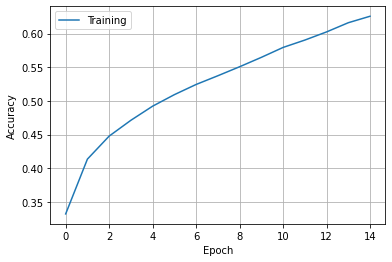

In [19]:
plt.plot(trainHistory.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [20]:
model.evaluate(data_test, verbose=2)

157/157 - 1s - loss: 309.8881 - accuracy: 0.4034 - 1s/epoch - 7ms/step


[309.8880615234375, 0.4034000039100647]

In [21]:
(_,y_true) = to_array(data_test.unbatch())
y_pred = np.argmax(model.predict(data_test),axis=-1)

In [22]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.77      0.50       520
           1       0.78      0.33      0.46       493
           2       0.65      0.12      0.20       478
           3       0.38      0.10      0.16       517
           4       0.93      0.03      0.05       476
           5       0.28      0.66      0.39       524
           6       0.98      0.08      0.15       507
           7       0.55      0.56      0.56       496
           8       0.72      0.49      0.58       506
           9       0.31      0.88      0.46       483

    accuracy                           0.40      5000
   macro avg       0.59      0.40      0.35      5000
weighted avg       0.59      0.40      0.35      5000



In [23]:
pd.DataFrame(confusion_matrix(y_true,y_pred))

,0,1,2,3,4,5,6,7,8,9
0,398,2,2,1,0,11,0,7,19,80
1,37,161,0,0,0,12,0,4,14,265
2,134,4,55,12,1,158,1,45,7,61
3,79,8,3,53,0,250,0,24,14,86
4,120,3,13,17,13,147,0,81,18,64
5,58,1,2,22,0,345,0,39,7,50
6,68,4,6,24,0,222,41,24,4,114
7,63,3,3,6,0,56,0,279,3,83
8,98,8,1,3,0,24,0,2,247,123
9,28,13,0,2,0,4,0,2,9,425
